In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# Обработка данных
Импортируем данные и посмотрим на них.

In [10]:
raw_data = pd.read_csv("../data/waterQuality1.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [15]:
raw_data.isnull().sum()

aluminium      0
ammonia        0
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        0
dtype: int64

Пропущенных значений нет.

In [16]:
raw_data.isna().sum()

aluminium      0
ammonia        0
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        0
dtype: int64

Pandas показывает, что мусора среди данных тоже нет, но путём физического просмотра данных, удалось найти 3 объекта, содержащие неожиданные значений, удалим их:

In [17]:
raw_data.drop([7551, 7568, 7890], axis=0, inplace=True)

features = raw_data.columns[:-1]
target = raw_data.columns[-1]
raw_data.shape

(7996, 21)

Нарисуем диаграммы рассеивания для каждого признака:

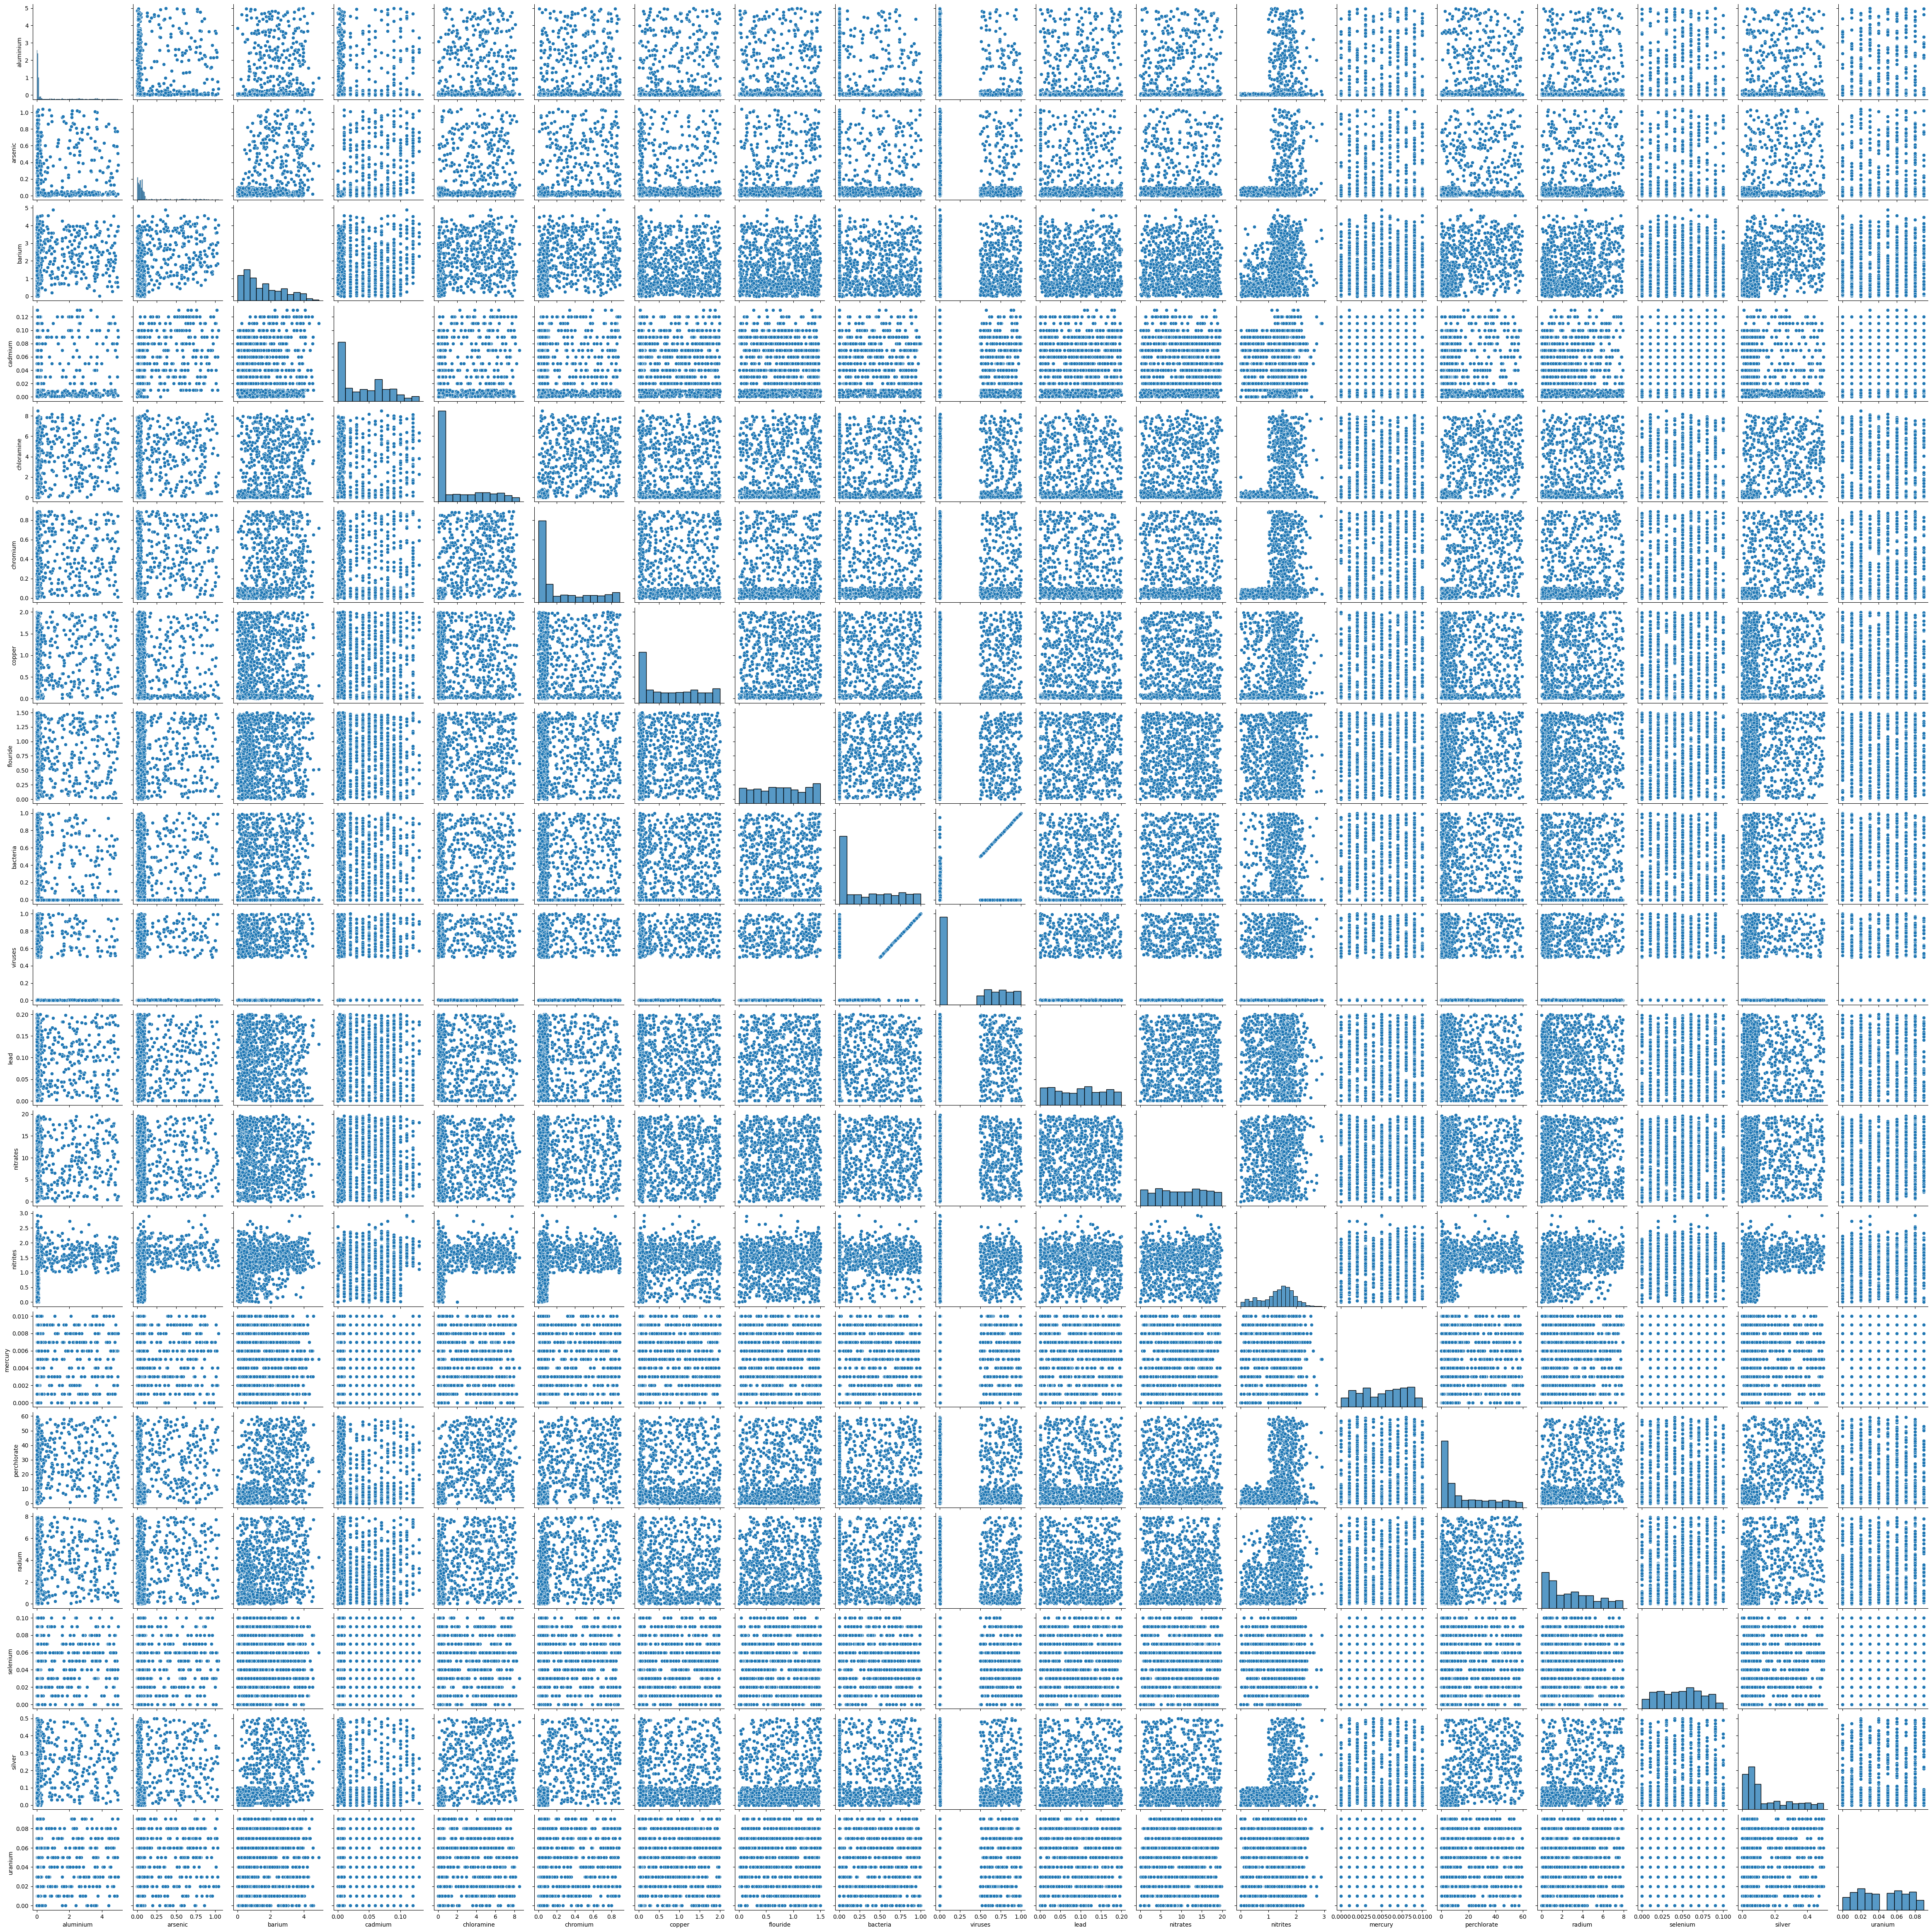

In [5]:
sns.pairplot(raw_data.sample(1000), diag_kind='hist')

Нарисуем бокссплоты для определения выбросов:

<AxesSubplot: >

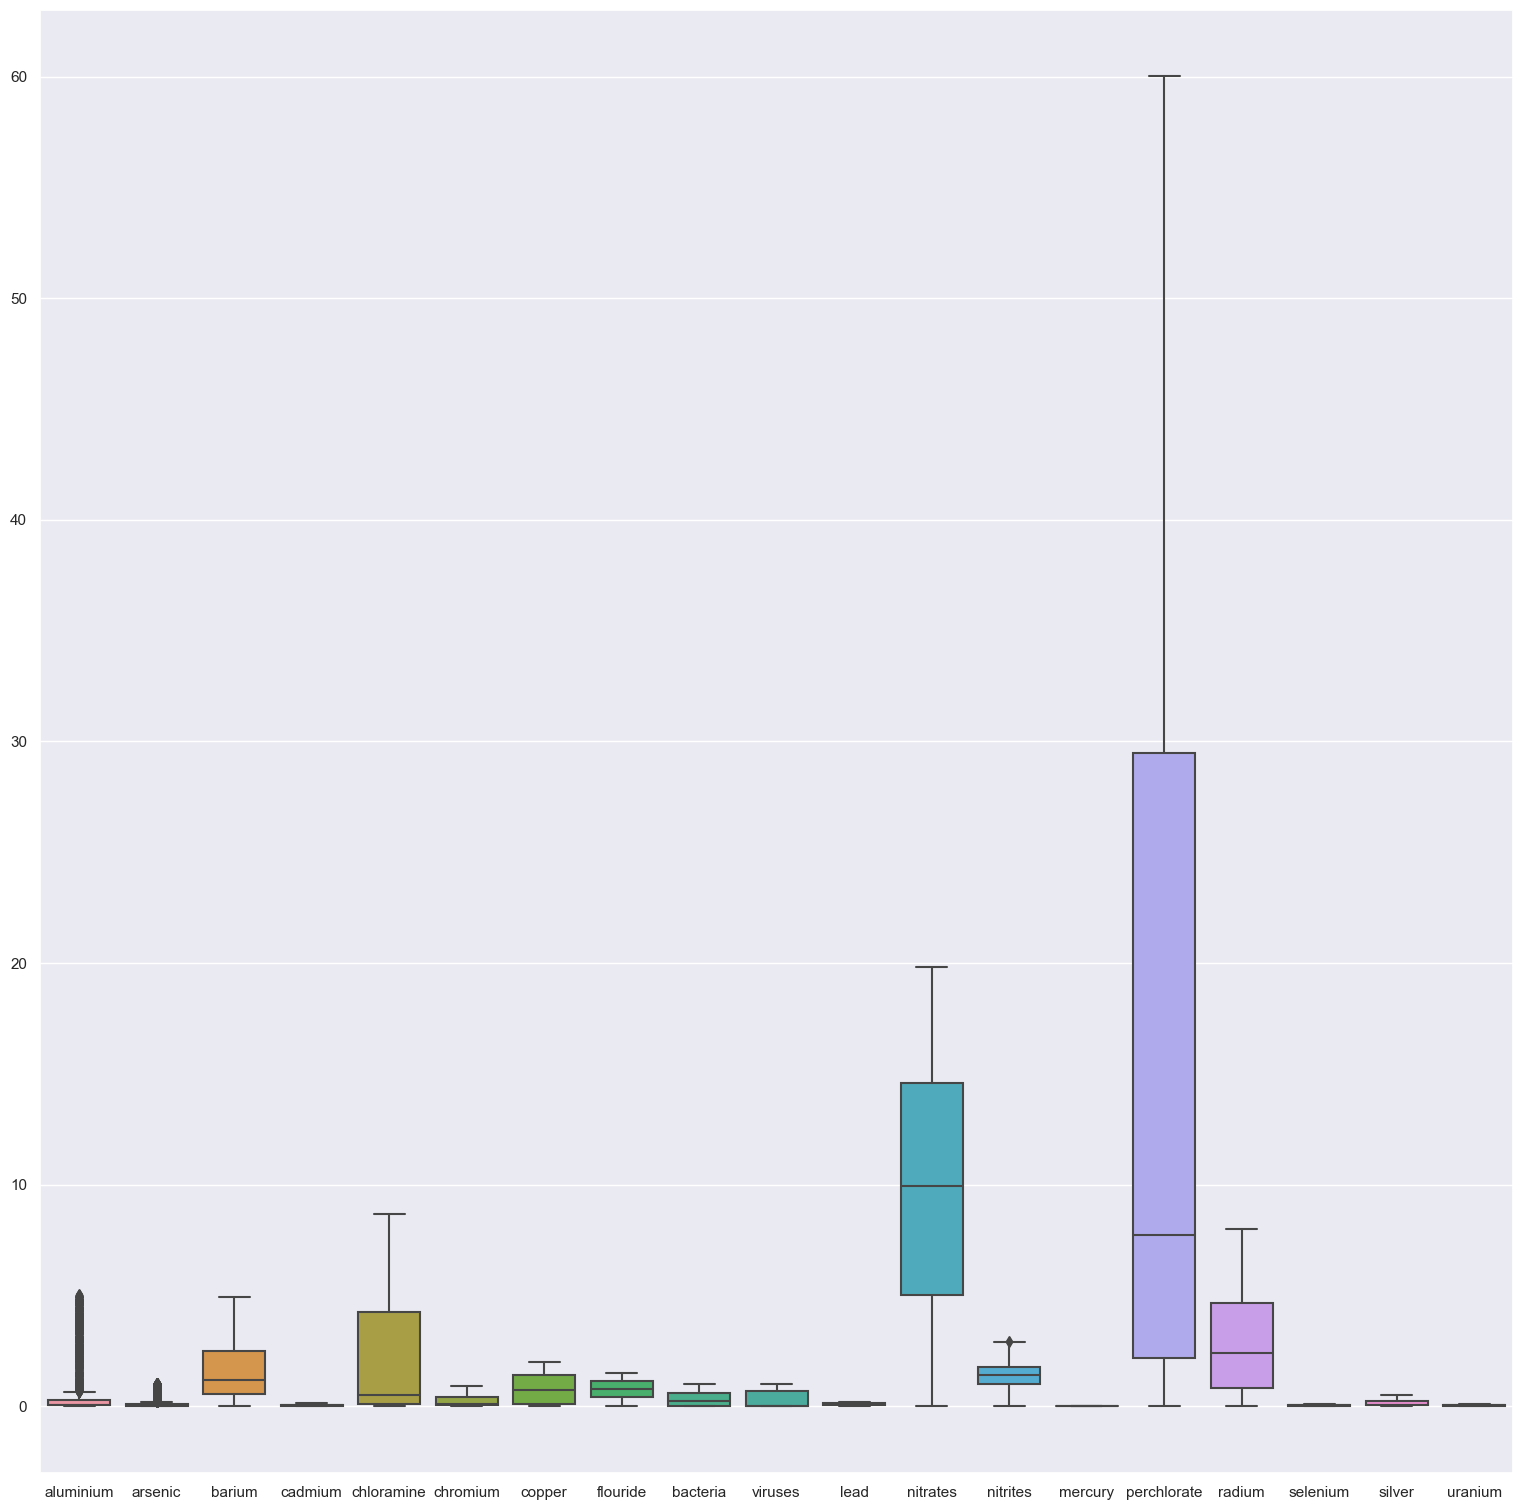

In [ ]:
plt.figure(figsize=(19, 19))
sns.boxplot(raw_data)

Множество выбросов наблюдается в признаках aluminium и arsenic, но по диаграммам видно, что они распределены равномерно и составляют значительную часть датасета, поэтому предлагается не убирать эти строки.

<AxesSubplot: ylabel='Count'>

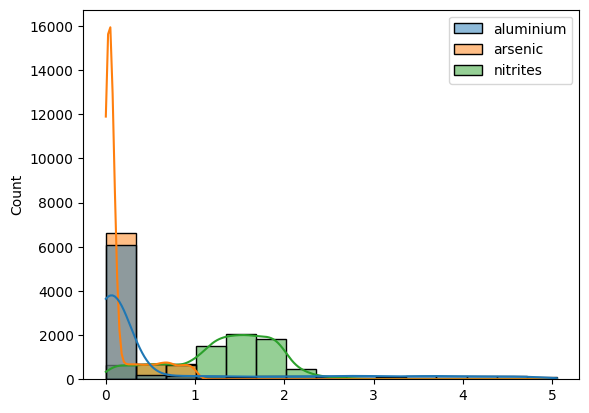

In [8]:
sns.histplot(data=raw_data[['aluminium', 'arsenic', 'nitrites']], kde=True, bins=15)

array([[<AxesSubplot: title={'center': 'aluminium'}>,
        <AxesSubplot: title={'center': 'arsenic'}>,
        <AxesSubplot: title={'center': 'barium'}>,
        <AxesSubplot: title={'center': 'cadmium'}>],
       [<AxesSubplot: title={'center': 'chloramine'}>,
        <AxesSubplot: title={'center': 'chromium'}>,
        <AxesSubplot: title={'center': 'copper'}>,
        <AxesSubplot: title={'center': 'flouride'}>],
       [<AxesSubplot: title={'center': 'bacteria'}>,
        <AxesSubplot: title={'center': 'viruses'}>,
        <AxesSubplot: title={'center': 'lead'}>,
        <AxesSubplot: title={'center': 'nitrates'}>],
       [<AxesSubplot: title={'center': 'nitrites'}>,
        <AxesSubplot: title={'center': 'mercury'}>,
        <AxesSubplot: title={'center': 'perchlorate'}>,
        <AxesSubplot: title={'center': 'radium'}>],
       [<AxesSubplot: title={'center': 'selenium'}>,
        <AxesSubplot: title={'center': 'silver'}>,
        <AxesSubplot: title={'center': 'uranium'}>, 

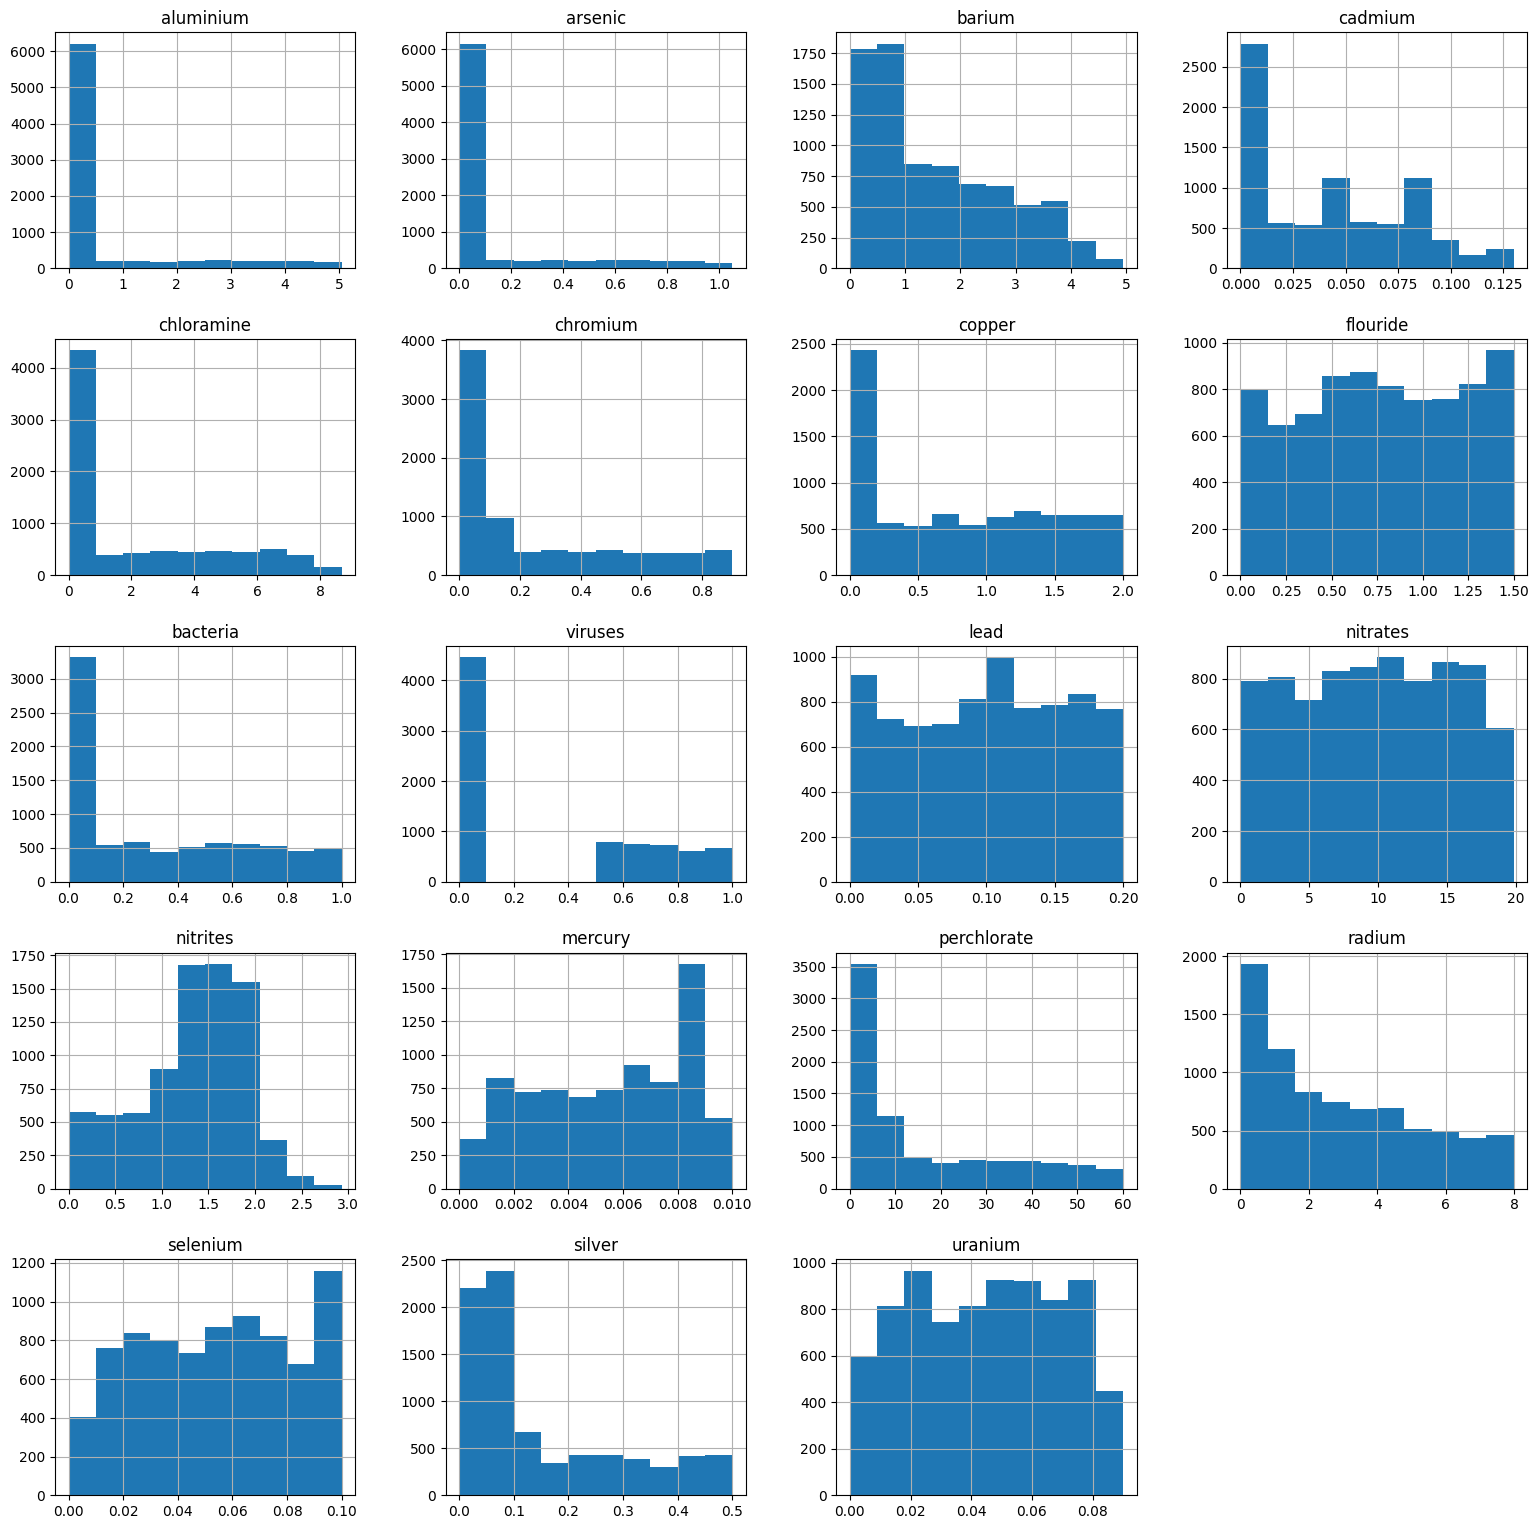

In [23]:
raw_data[:-1].hist(figsize=(19, 19))

Построим матрицу корреляции для признаков датасета:

<AxesSubplot: >

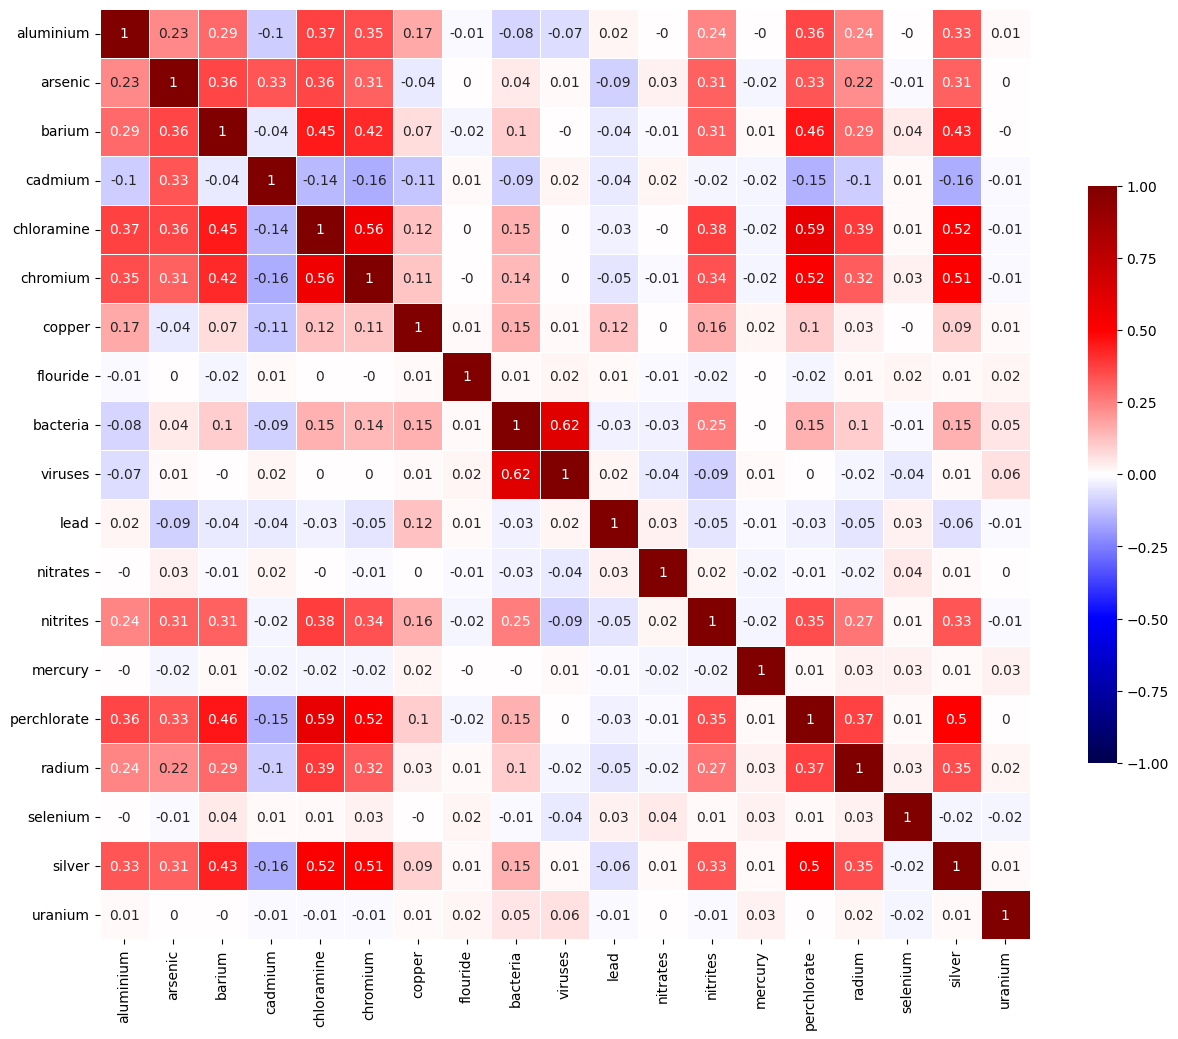

In [18]:
corr_mat = raw_data[:-1].corr(numeric_only=True)
corr_mat = corr_mat.round(decimals=2)
corr_mat

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr_mat, cmap="seismic", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

Сильной корреляции между какой-либо парой признаков не наблюдается.

# Выбор моделей и обучение классификаторов
Выберем три модели классификаторов: RandomForestClassifier, CatBoost GBDT и KNeigborsClassifier. Для каждой модели получим базовые результаты, после чего проанализируем их и попробуем предобработать исходные данные для и подобрать значения гиперпараметров для получения лучших результатов.

Разделим датасет на признаки и целевую переменную:

In [20]:
X = raw_data.drop(['is_safe'], axis=1)
Y = raw_data['is_safe']

Напишем функцию, которая будет обучать и тестировать классификаторы, а также выдавать информацию о качестве модели:

In [46]:
def train_test(model, X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 41)
    trained_model = model.fit(X_Train, Y_Train)
    y_pred = trained_model.predict(X_Test)
    y_true = Y_Test.astype(y_pred.dtype)
    print(classification_report(y_pred, y_true))
    print(f'accuracy: {accuracy_score(y_true, y_pred)}')

Получим первые результаты:

In [47]:
model1 = CatBoostClassifier(silent=True, loss_function='CrossEntropy', learning_rate=0.1)
model2 = KNeighborsClassifier(n_neighbors=5)
model3 = RandomForestClassifier(n_estimators=100)

train_test(model1, X, Y)
train_test(model2, X, Y)
train_test(model3, X, Y)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2181
           1       0.81      0.95      0.87       218

    accuracy                           0.97      2399
   macro avg       0.90      0.96      0.93      2399
weighted avg       0.98      0.97      0.98      2399

accuracy: 0.9749895789912464
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2324
           1       0.13      0.45      0.21        75

    accuracy                           0.89      2399
   macro avg       0.56      0.68      0.57      2399
weighted avg       0.95      0.89      0.92      2399

accuracy: 0.8903709879116298
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2217
           1       0.68      0.96      0.80       182

    accuracy                           0.96      2399
   macro avg       0.84      0.96      0.89      2399
weighted avg    

Видим, что наилучшую точность показывает модель CatBoost, следом идёт модель случайного леса, затем алгоритм K ближайших соседей. Попробуем для модели KNeighborsClassifier масштабировать данные к отрезку [0, 1]:

In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_data[features])
data = pd.DataFrame(scaler.transform(raw_data[features]), columns = features, index = raw_data.index)
data = pd.concat([data, raw_data[target]], axis=1)
data

aluminium   ammonia   arsenic    barium   cadmium  chloramine  chromium  \
0      0.326733  0.306150  0.038095  0.576923  0.053846    0.040323  0.922222   
1      0.459406  0.709893  0.009524  0.670040  0.015385    0.608295  0.755556   
2      0.200000  0.471257  0.038095  0.117409  0.061538    0.488479  0.588889   
3      0.269307  0.381350  0.038095  0.599190  0.007692    0.832949  0.033333   
4      0.182178  0.815842  0.028571  0.040486  0.046154    0.307604  0.766667   
...         ...       ...       ...       ...       ...         ...       ...   
7994   0.009901  0.262701  0.000000  0.394737  0.307692    0.011521  0.033333   
7995   0.009901  0.812166  0.019048  0.119433  0.076923    0.051843  0.022222   
7996   0.017822  0.231618  0.000000  0.123482  0.230769    0.005760  0.055556   
7997   0.001980  0.336898  0.009524  0.404858  0.000000    0.230415  0.000000   
7998   0.007921  0.231618  0.009524  0.141700  0.230769    0.005760  0.011111   

      copper  flouride  bacteria  ...   lead  nitrates  nitrites  mercury  \
0      0.085  0.033333      0.20  ...  0.270  0.810893  0.385666      0.7   
1      0.330  0.600000      0.65  ...  0.500  0.101362  0.658703      0.3   
2      0.010  0.660000      0.05  ...  0.390  0.714070  0.378840      0.6   
3      0.830  0.720000      0.71  ...  0.080  0.071104  0.440273      0.4   
4      0.285  0.406667      0.13  ...  0.585  0.339889  0.378840      0.3   
...      ...       ...       ...  ...    ...       ...       ...      ...   
7994   0.015  0.913333      0.00  ...  0.985  0.720625  0.341297      0.5   
7995   0.010  0.986667      0.00  ...  0.155  0.517902  0.341297      0.1   
7996   0.010  0.606667      0.00  ...  0.910  0.802824  0.341297      0.0   
7997   0.045  0.000000      0.00  ...  0.000  0.000000  0.000000      0.0   
7998   0.015  0.666667      0.00  ...  0.910  0.802824  0.341297      0.0   

      perchlorate    radium  selenium  silver   uranium  is_safe  
0        0.629062  0.848561       0.8    0.68  0.222222        1  
1        0.537577  0.401752       0.8    0.54  0.555556        1  
2        0.837860  0.884856       0.7    0.88  0.111111        0  
3        0.151975  0.215269       0.2    0.90  0.555556        1  
4        0.281620  0.301627       0.2    0.12  0.222222        1  
...           ...       ...       ...     ...       ...      ...  
7994     0.059490  0.266583       0.9    0.12  0.333333        1  
7995     0.024663  0.138924       0.9    0.20  0.888889        1  
7996     0.022496  0.605757       0.0    0.08  0.555556        1  
7997     0.000000  0.000000       0.0    0.00  0.000000        1  
7998     0.022496  0.605757       0.0    0.08  0.555556        1  

[7996 rows x 21 columns]

In [49]:
scaled_X = data.drop(['is_safe'], axis=1)
scaled_Y = data['is_safe']

model = KNeighborsClassifier(n_neighbors=5)

train_test(model, scaled_X, scaled_Y)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2258
           1       0.35      0.63      0.45       141

    accuracy                           0.91      2399
   macro avg       0.66      0.78      0.70      2399
weighted avg       0.94      0.91      0.92      2399

accuracy: 0.9087119633180492


Видим, что точность поднялась почти на 3%, попробуем подобрать оптимальные значения гиперпараметров:

In [50]:
leaf_size = range(1, 5)
n_neighbors = range(1, 12)
p= [1]
model = KNeighborsClassifier()
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

clf = GridSearchCV(model, hyperparameters, cv=5)

best_model = clf.fit(scaled_X, scaled_Y)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

train_test(best_model, scaled_X, scaled_Y)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 2
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2338
           1       0.19      0.80      0.31        61

    accuracy                           0.91      2399
   macro avg       0.59      0.86      0.63      2399
weighted avg       0.97      0.91      0.93      2399

accuracy: 0.9087119633180492


Повышения точности достичь на удалось. Проведём подбор гиперпараметров для модели случайного леса:

In [51]:
n_estimators = range(100, 300, 30)
model = RandomForestClassifier()
hyperparameters = dict(n_estimators=n_estimators)

clf = GridSearchCV(model, hyperparameters, cv=5)

best_model = clf.fit(scaled_X, scaled_Y)

print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])

train_test(best_model, X, Y)

Best n_estimators: 220
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2218
           1       0.68      0.97      0.80       181

    accuracy                           0.96      2399
   macro avg       0.84      0.97      0.89      2399
weighted avg       0.97      0.96      0.97      2399

accuracy: 0.9637348895373072


Точность лишь слегка повысилась. Проведём наконец подбор гиперпараметров для модели GBDT CatBoost:

In [41]:
model = CatBoostClassifier(silent=True, loss_function='CrossEntropy')

grid = {'learning_rate': [0.01, 0.1, 0.2],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [3, 4, 5]}
grid_search_result = model.grid_search(grid, X=X, y=Y, plot=True, cv=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1106204382
bestIteration = 999

0:	loss: 0.1106204	best: 0.1106204 (0)	total: 5.01s	remaining: 2m 10s

bestTest = 0.08536589724
bestIteration = 627

1:	loss: 0.0853659	best: 0.0853659 (1)	total: 8.6s	remaining: 1m 47s

bestTest = 0.09102037005
bestIteration = 264

2:	loss: 0.0910204	best: 0.0853659 (1)	total: 11.2s	remaining: 1m 29s

bestTest = 0.1107456255
bestIteration = 999

3:	loss: 0.1107456	best: 0.0853659 (1)	total: 15.2s	remaining: 1m 27s

bestTest = 0.08404915664
bestIteration = 505

4:	loss: 0.0840492	best: 0.0840492 (4)	total: 20s	remaining: 1m 27s

bestTest = 0.09032303491
bestIteration = 259

5:	loss: 0.0903230	best: 0.0840492 (4)	total: 23.7s	remaining: 1m 23s

bestTest = 0.1113809494
bestIteration = 999

6:	loss: 0.1113809	best: 0.0840492 (4)	total: 27.2s	remaining: 1m 17s

bestTest = 0.08480361357
bestIteration = 600

7:	loss: 0.0848036	best: 0.0840492 (4)	total: 29.9s	remaining: 1m 11s

bestTest = 0.08729550598
bestIteration = 322

8:	loss: 0.0872955	best

In [45]:
model = CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=2, learning_rate=0.2, loss_function='CrossEntropy')

train_test(model, X, Y)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2181
           1       0.81      0.95      0.88       218

    accuracy                           0.98      2399
   macro avg       0.90      0.97      0.93      2399
weighted avg       0.98      0.98      0.98      2399

0.9758232596915382
